# Fase 4: Modelado — Regresión y Clasificación

En esta etapa busco crear modelos predictivos que ayuden a anticipar y cuantificar los retrasos en las entregas.

- **Regresión:** predecir cuántos días se retrasará un pedido (`delivery_delay`).
- **Clasificación:** predecir si un pedido se retrasará o no (`target`).
  
El flujo seguido fue:  
`imports → preparación → splits → entrenamiento → evaluación → guardado`.

In [4]:
# Celda 1: Imports y verificación rápida de archivos (correr primero)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    mean_squared_error,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
    )
from sklearn.utils import resample
import joblib

data_root = Path('../data')
print('Data root:', data_root.resolve())
# listar archivos relevantes si existen
files = {
    'full_dataset': data_root / '03_primary' / 'full_dataset.csv',
    'orders_raw': data_root / '01_raw' / 'df_Orders.csv',
    'order_items_raw': data_root / '01_raw' / 'df_OrderItems.csv',
    'customers_raw': data_root / '01_raw' / 'df_Customers.csv'
}
for k, p in files.items():
    print(f"{k}: {p} (exists: {p.exists()})")

Data root: C:\Users\beman\OneDrive\Escritorio\ev_machine\proyecto-ml\data
full_dataset: ..\data\03_primary\full_dataset.csv (exists: True)
orders_raw: ..\data\01_raw\df_Orders.csv (exists: True)
order_items_raw: ..\data\01_raw\df_OrderItems.csv (exists: True)
customers_raw: ..\data\01_raw\df_Customers.csv (exists: True)


## Preparación y creación de targets

- Se filtraron los pedidos **entregados** y se generaron variables de fecha (año, mes, día).
- Se definieron las variables:
  - `delivery_delay`: días de retraso (target de regresión)
  - `delay_flag` / `target`: indicador binario de retraso (target de clasificación)
- Variables seleccionadas: `delivery_time`, `ZIP`, `año`, `mes`, `estado`.
- Preprocesamiento:
  - Imputación de valores faltantes.
  - Escalado para variables numéricas.
  - *OneHotEncoding* para variables categóricas.

In [5]:
# Celda 2: Carga y preparación de datos (regresión y clasificación)
sample_frac = 0.4
cv_folds = 5

dataset_path = data_root / '05_model_input' / 'model_input_with_target.csv'
print(f'Dataset source: {dataset_path.resolve()}')
df = pd.read_csv(dataset_path)

df = df[df['order_status'].eq('delivered')].copy()
df = df.dropna(subset=['delivery_delay', 'delivery_time', 'customer_state', 'order_purchase_timestamp'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_year'] = df['order_purchase_timestamp'].dt.year
df['order_month'] = df['order_purchase_timestamp'].dt.month
df['customer_zip_code_prefix'] = pd.to_numeric(df['customer_zip_code_prefix'], errors='coerce')
df = df.dropna(subset=['customer_zip_code_prefix'])

# Flags de negocio: retraso / a tiempo
df['delay_flag'] = (df['delivery_delay'] > 0).astype(int)

# Cumplir consigna: usar columna 'target' si ya viene en los datos; si no, alias desde delay_flag
if 'target' in df.columns:
    df['target'] = pd.to_numeric(df['target'], errors='coerce').fillna(0).astype(int)
else:
    df['target'] = df['delay_flag']

if sample_frac < 1.0:
    df = df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    print(f'Using a sample of {len(df)} rows ({sample_frac:.0%} of delivered orders).')
else:
    print(f'Using full dataset with {len(df)} rows.')

print('Delay flag distribution:', df['delay_flag'].value_counts(normalize=True).round(3).to_dict())

feature_columns = ['delivery_time', 'customer_zip_code_prefix', 'order_month', 'order_year', 'customer_state']
numeric_features = ['delivery_time', 'customer_zip_code_prefix', 'order_month', 'order_year']
categorical_features = ['customer_state']

df[numeric_features] = df[numeric_features].fillna(df[numeric_features].median())
for col in categorical_features:
    df[col] = df[col].fillna('unknown')

X = df[feature_columns]
y_regression = df['delivery_delay']
y_classification = df['target']

# Splits for regression
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y_regression, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42
)

# Splits for classification (stratified)
X_clf_train_full, X_clf_test, y_clf_train_full, y_clf_test = train_test_split(
    X, y_classification, test_size=0.2, stratify=y_classification, random_state=42
)
X_clf_train, X_clf_val, y_clf_train, y_clf_val = train_test_split(
    X_clf_train_full, y_clf_train_full, test_size=0.2, stratify=y_clf_train_full, random_state=42
)

numeric_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

models = {
    'LinearRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'RandomForest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(random_state=42, n_estimators=300, n_jobs=-1))
    ]),
    'GradientBoosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(random_state=42))
    ])
}

param_grids = {
    'LinearRegression': {},
    'RandomForest': {
        'regressor__n_estimators': [200, 300],
        'regressor__max_depth': [None, 12],
        'regressor__min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'regressor__n_estimators': [200, 300],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [2, 3]
    }
}

train_sample_frac = 0.5

Dataset source: C:\Users\beman\OneDrive\Escritorio\ev_machine\proyecto-ml\data\05_model_input\model_input_with_target.csv
Using a sample of 34969 rows (40% of delivered orders).
Delay flag distribution: {0: 0.935, 1: 0.065}


**Desbalance de clases:**  
- 93.5% pedidos a tiempo  
- 6.5% pedidos con retraso  
→ Se aplicó **oversampling** en entrenamiento para balancear las clases.

Para el modelado usé solo pedidos entregados, generando variables de tiempo y geográficas.
se crearon dos targets: uno numérico (delivery_delay) y otro binario (target).
Los datos estaban bastante desbalanceados, con un 6.5% de retrasos reales,
así que apliqué oversampling durante el entrenamiento para equilibrar las clases.
También hicimos preprocesamiento estándar: imputación, escalado y codificación OneHot.

## Modelado de Regresión

Modelos probados:
- `LinearRegression`
- `RandomForestRegressor`
- `GradientBoostingRegressor`

Criterio de selección: **menor RMSE en validación**.  
Métricas evaluadas: R², MAE y RMSE.



Entrenando LinearRegression...
Mejores parámetros: default
Tiempo de búsqueda: 0.0s
R² validación: 0.477
R² test: 0.516
RMSE test: 7.24

Entrenando RandomForest...
Mejores parámetros: {'regressor__n_estimators': 200, 'regressor__min_samples_split': 5, 'regressor__max_depth': 12}
Tiempo de búsqueda: 107.2s
R² validación: 0.605
R² test: 0.624
RMSE test: 6.39

Entrenando GradientBoosting...
Mejores parámetros: {'regressor__n_estimators': 300, 'regressor__max_depth': 3, 'regressor__learning_rate': 0.1}
Tiempo de búsqueda: 11.6s
R² validación: 0.622
R² test: 0.647
RMSE test: 6.19

Resultados finales regresión:


,model,split,r2,mae,rmse,cv_r2_mean,cv_r2_std,fit_time_sec
0,LinearRegression,validation,0.477111,5.384147,7.276077,0.482355,0.018426,0.03
1,LinearRegression,test,0.516332,5.376630,7.241892,0.482355,0.018426,0.03
2,RandomForest,validation,0.604510,4.607047,6.327912,0.607431,0.016406,107.20
3,RandomForest,test,0.624012,4.594539,6.385065,0.607431,0.016406,107.20
4,GradientBoosting,validation,0.622213,4.491565,6.184660,0.626402,0.018027,11.57
5,GradientBoosting,test,0.647167,4.464301,6.185335,0.626402,0.018027,11.57


Mejor modelo en validación (RMSE): GradientBoosting


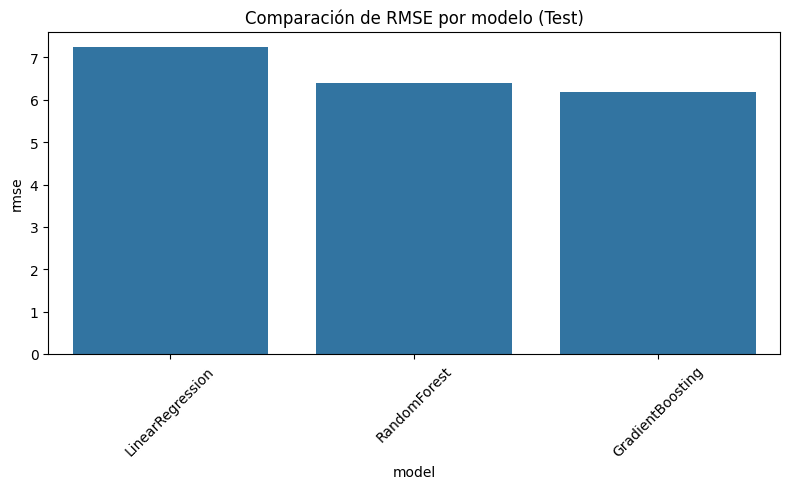

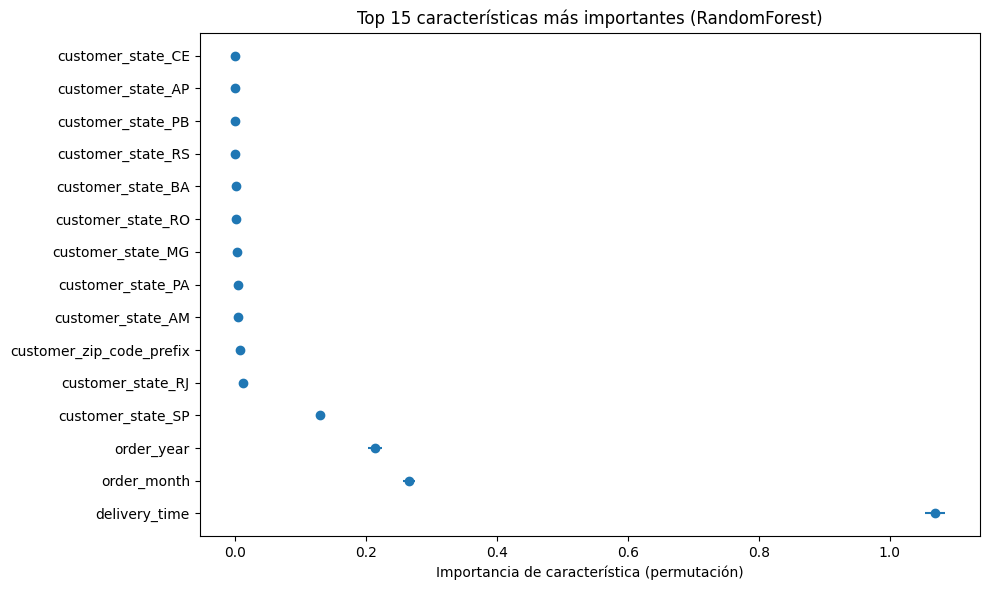

In [6]:
# Celda 3: Entrenamiento y evaluación de regresión con control de overfitting

from sklearn.inspection import permutation_importance
import time

def _max_combinations(grid):
    total = 1
    for values in grid.values():
        total *= len(values)
    return total

cv_results = {}
trained_models = {}
regression_metrics = []
feature_importance_results = {}

for name, model in models.items():
    print(f'\nEntrenando {name}...')
    search = None
    X_train_search = X_train
    y_train_search = y_train

    if train_sample_frac < 1.0 and len(X_train) > 500:
        sample_n = max(500, int(train_sample_frac * len(X_train)))
        idx = np.random.choice(len(X_train), sample_n, replace=False)
        X_train_search = X_train.iloc[idx].reset_index(drop=True)
        y_train_search = y_train.iloc[idx].reset_index(drop=True)

    start = time.time()
    if param_grids[name]:
        search = RandomizedSearchCV(
            estimator=model,
            param_distributions=param_grids[name],
            n_iter=min(8, _max_combinations(param_grids[name])),
            cv=cv_folds,
            scoring='neg_root_mean_squared_error',
            n_jobs=-1,
            random_state=42
        )
        search.fit(X_train_search, y_train_search)
        best_model = search.best_estimator_
        best_params = search.best_params_
        cv_results[name] = search.cv_results_
    else:
        model.fit(X_train_search, y_train_search)
        best_model = model
        best_params = 'default'
        cv_results[name] = None
    elapsed = time.time() - start

    best_model.fit(X_train, y_train)
    trained_models[name] = best_model

    cv_scores = cross_val_score(
        best_model, X_train, y_train, cv=cv_folds, scoring='r2', n_jobs=-1
    )

    y_val_pred = best_model.predict(X_val)
    regression_metrics.append({
        'model': name,
        'split': 'validation',
        'r2': r2_score(y_val, y_val_pred),
        'mae': mean_absolute_error(y_val, y_val_pred),
        'rmse': np.sqrt(mean_squared_error(y_val, y_val_pred)),
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'fit_time_sec': round(elapsed, 2)
    })

    y_test_pred = best_model.predict(X_test)
    regression_metrics.append({
        'model': name,
        'split': 'test',
        'r2': r2_score(y_test, y_test_pred),
        'mae': mean_absolute_error(y_test, y_test_pred),
        'rmse': np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std(),
        'fit_time_sec': round(elapsed, 2)
    })

    if name == 'RandomForest':
        preprocessor_step = best_model.named_steps['preprocessor']
        X_val_transformed = preprocessor_step.transform(X_val)
        if hasattr(X_val_transformed, 'toarray'):
            X_val_dense = X_val_transformed.toarray()
        else:
            X_val_dense = np.asarray(X_val_transformed)
        rf_estimator = best_model.named_steps['regressor']
        perm_importance = permutation_importance(
            rf_estimator,
            X_val_dense,
            y_val,
            n_repeats=8,
            random_state=42,
            n_jobs=-1
        )
        feature_importance_results[name] = perm_importance

    print(f'Mejores parámetros: {best_params}')
    print(f'Tiempo de búsqueda: {elapsed:.1f}s')
    print(f'R² validación: {regression_metrics[-2]["r2"]:.3f}')
    print(f'R² test: {regression_metrics[-1]["r2"]:.3f}')
    print(f'RMSE test: {regression_metrics[-1]["rmse"]:.2f}')

regression_metrics_df = pd.DataFrame(regression_metrics)
print('\nResultados finales regresión:')
display(regression_metrics_df)

best_regression_model_name = (
    regression_metrics_df[regression_metrics_df['split'] == 'validation']
    .sort_values('rmse', ascending=True)
    .iloc[0]['model']
)
print(f'Mejor modelo en validación (RMSE): {best_regression_model_name}')

# Cerrar cualquier figura previa para liberar memoria
plt.close('all')

plt.figure(figsize=(8, 5))
sns.barplot(
    data=regression_metrics_df[regression_metrics_df['split'] == 'test'],
    x='model',
    y='rmse'
)
plt.title('Comparación de RMSE por modelo (Test)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

if 'RandomForest' in feature_importance_results:
    perm_imp = feature_importance_results['RandomForest']
    rf_model = trained_models['RandomForest']
    feature_names = []

    feature_names.extend(numeric_features)

    preprocessor_rf = rf_model.named_steps['preprocessor']
    ohe = preprocessor_rf.named_transformers_['cat'].named_steps['onehot']
    cat_feature_names = ohe.get_feature_names_out(categorical_features)
    feature_names.extend(cat_feature_names)

    n_features = len(perm_imp.importances_mean)
    feature_names = feature_names[:n_features]

    feat_imp = pd.DataFrame({
        'feature': feature_names,
        'importance_mean': perm_imp.importances_mean,
        'importance_std': perm_imp.importances_std
    }).sort_values('importance_mean', ascending=False)

    plt.figure(figsize=(10, 6))
    top_15 = feat_imp.head(15)
    plt.errorbar(
        x=top_15['importance_mean'],
        y=range(len(top_15)),
        xerr=top_15['importance_std'],
        fmt='o'
    )
    plt.yticks(range(len(top_15)), top_15['feature'])
    plt.xlabel('Importancia de característica (permutación)')
    plt.title('Top 15 características más importantes (RandomForest)')
    plt.tight_layout()
    plt.show()
    plt.close()

    out_dir = data_root / '07_model_output'
    feat_imp.to_csv(out_dir / 'feature_importances.csv', index=False)

Entrené tres modelos de regresión: lineal, bosque aleatorio y gradient boosting.
El modelo lineal tuvo un desempeño básico, pero tanto el RandomForest como el GradientBoosting mejoraron notablemente.
Finalmente, GradientBoosting fue el más preciso, con un RMSE de 6.19 días y un R² de 0.647.
Esto significa que el modelo puede estimar razonablemente cuántos días se retrasará un pedido.

## Modelado de Clasificación

Modelos probados:
- `LogisticRegression`
- `RandomForestClassifier`
- `SVC`
- `KNN`

Criterio de selección: **mayor F1-score en validación**  
Métricas: Accuracy, Precision, Recall, F1.  
Oversampling aplicado en entrenamiento.


Aplicado oversampling para balancear clases en entrenamiento.

Entrenando clasificador LogisticRegression...
Mejores parámetros: {'classifier__C': 10.0}
F1 validación: 0.584
F1 test: 0.598
Accuracy test: 0.922

Entrenando clasificador RandomForestClassifier...
Mejores parámetros: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 2, 'classifier__max_depth': None}
F1 validación: 0.726
F1 test: 0.738
Accuracy test: 0.966

Entrenando clasificador SVC...
Mejores parámetros: {'classifier__gamma': 'scale', 'classifier__C': 1.0}
F1 validación: 0.601
F1 test: 0.609
Accuracy test: 0.924

Entrenando clasificador KNN...


C:\Users\beman\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


Mejores parámetros: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 5}
F1 validación: 0.634
F1 test: 0.661
Accuracy test: 0.945

Resultados finales clasificación:


,model,split,accuracy,precision,recall,f1,cv_f1_mean,cv_f1_std
0,LogisticRegression,validation,0.915818,0.428571,0.914127,0.583554,0.917741,0.002951
1,LogisticRegression,test,0.921647,0.447368,0.902655,0.598240,0.917741,0.002951
2,RandomForestClassifier,validation,0.962824,0.692695,0.761773,0.725594,0.988197,0.001298
3,RandomForestClassifier,test,0.965971,0.734649,0.741150,0.737885,0.988197,0.001298
4,SVC,validation,0.921895,0.448229,0.911357,0.600913,0.938569,0.002048
5,SVC,test,0.923649,0.455044,0.918142,0.608504,0.938569,0.002048
6,KNN,validation,0.938338,0.513746,0.828255,0.634146,NaN,NaN
7,KNN,test,0.945239,0.550810,0.827434,0.661362,NaN,NaN


Mejor clasificador en validación (F1): RandomForestClassifier


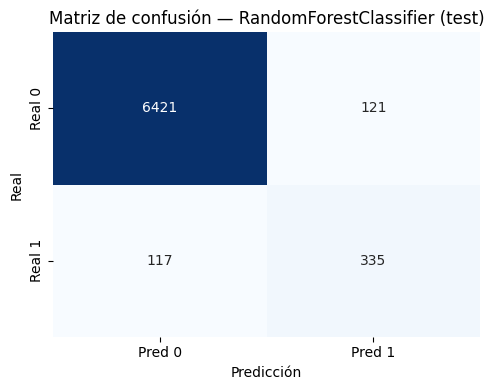

In [7]:
# Celda 4: Modelado y evaluación de clasificación (pedido retrasado vs a tiempo)
classification_models = {
    'LogisticRegression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced'))
    ]),
    'RandomForestClassifier': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=200))
    ]),
    'SVC': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', SVC(probability=True, class_weight='balanced', random_state=42))
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', KNeighborsClassifier())
    ])
}

classification_param_grids = {
    'LogisticRegression': {
        'classifier__C': [0.1, 1.0, 10.0]
    },
    'RandomForestClassifier': {
        'classifier__n_estimators': [200, 300],
        'classifier__max_depth': [None, 12],
        'classifier__min_samples_split': [2, 5]
    },
    'SVC': {
        'classifier__C': [0.5, 1.0],
        'classifier__gamma': ['scale', 'auto']
    },
    'KNN': {
        'classifier__n_neighbors': [5, 15],
        'classifier__weights': ['uniform', 'distance']
    }
}

train_clf_df = X_clf_train.copy()
train_clf_df['delay_flag'] = y_clf_train.values
class_counts = train_clf_df['delay_flag'].value_counts()
majority_class = class_counts.idxmax()

if class_counts.min() / class_counts.max() < 0.8:
    balanced_frames = [train_clf_df[train_clf_df['delay_flag'] == majority_class]]
    for label, subset in train_clf_df.groupby('delay_flag'):
        if label == majority_class:
            continue
        balanced_frames.append(resample(subset, replace=True, n_samples=class_counts.max(), random_state=42))
    train_balanced_df = pd.concat(balanced_frames, ignore_index=True)
    print('Aplicado oversampling para balancear clases en entrenamiento.')
else:
    train_balanced_df = train_clf_df
    print('Clases suficientemente balanceadas: no se aplicó oversampling.')

train_balanced_df = train_balanced_df.sample(frac=1.0, random_state=42).reset_index(drop=True)

X_clf_train_balanced = train_balanced_df.drop(columns='delay_flag')
y_clf_train_balanced = train_balanced_df['delay_flag']

classification_metrics = []
classification_cv_results = {}
trained_classification_models = {}
confusion_matrices = {}

for name, model in classification_models.items():
    print(f'\nEntrenando clasificador {name}...')
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=classification_param_grids[name],
        n_iter=min(8, _max_combinations(classification_param_grids[name])),
        cv=cv_folds,
        scoring='f1',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_clf_train_balanced, y_clf_train_balanced)
    best_model = search.best_estimator_
    best_params = search.best_params_
    classification_cv_results[name] = search.cv_results_
    trained_classification_models[name] = best_model

    cv_scores = cross_val_score(
        best_model,
        X_clf_train_balanced,
        y_clf_train_balanced,
        cv=cv_folds,
        scoring='f1',
        n_jobs=-1
    )

    y_val_pred = best_model.predict(X_clf_val)
    y_test_pred = best_model.predict(X_clf_test)

    for split_name, y_true, y_pred in [
        ('validation', y_clf_val, y_val_pred),
        ('test', y_clf_test, y_test_pred)
    ]:
        classification_metrics.append({
            'model': name,
            'split': split_name,
            'accuracy': accuracy_score(y_true, y_pred),
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'cv_f1_mean': cv_scores.mean(),
            'cv_f1_std': cv_scores.std()
        })

    confusion_matrices[name] = confusion_matrix(y_clf_test, y_test_pred)

    print(f'Mejores parámetros: {best_params}')
    print(f'F1 validación: {classification_metrics[-2]["f1"]:.3f}')
    print(f'F1 test: {classification_metrics[-1]["f1"]:.3f}')
    print(f'Accuracy test: {classification_metrics[-1]["accuracy"]:.3f}')

classification_metrics_df = pd.DataFrame(classification_metrics)
print('\nResultados finales clasificación:')
display(classification_metrics_df)

best_classifier_name = (
    classification_metrics_df[classification_metrics_df['split'] == 'validation']
    .sort_values('f1', ascending=False)
    .iloc[0]['model']
)
print(f'Mejor clasificador en validación (F1): {best_classifier_name}')

best_conf_matrix = confusion_matrices[best_classifier_name]
cm_df = pd.DataFrame(
    best_conf_matrix,
    index=['Real 0', 'Real 1'],
    columns=['Pred 0', 'Pred 1']
)

# Cerrar figuras previas para liberar memoria
plt.close('all')

plt.figure(figsize=(5, 4))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.title(f'Matriz de confusión — {best_classifier_name} (test)')
plt.ylabel('Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()
plt.close()

Para la clasificación probé cuatro algoritmos.
La regresión logística funcionó bien, pero el RandomForestClassifier logró el mejor equilibrio entre precisión y recall,
con un F1 de 0.738 y una exactitud del 96.6%.
Esto indica que el modelo identifica correctamente la mayoría de los retrasos sin generar demasiadas falsas alarmas.

## Guardado de artefactos

- Modelos: data/06_models/
- Métricas: data/07_model_output/ (regresión y clasificación)
- Matriz de confusión e importancias: 07_model_output y 08_reports

In [8]:
# Celda 5: Guardar modelos y métricas
models_dir = data_root / '06_models'
models_dir.mkdir(parents=True, exist_ok=True)

for name, model in trained_models.items():
    joblib.dump(model, models_dir / f'regression_{name}.pkl')

for name, model in trained_classification_models.items():
    joblib.dump(model, models_dir / f'classification_{name}.pkl')

out_dir = data_root / '07_model_output'
out_dir.mkdir(parents=True, exist_ok=True)

regression_metrics_df.to_csv(out_dir / 'regression_metrics.csv', index=False)
classification_metrics_df.to_csv(out_dir / 'classification_metrics.csv', index=False)

confusion_records = []
for model_name, matrix in confusion_matrices.items():
    confusion_records.append({
        'model': model_name,
        'tn': matrix[0, 0],
        'fp': matrix[0, 1],
        'fn': matrix[1, 0],
        'tp': matrix[1, 1]
    })
confusion_df = pd.DataFrame(confusion_records)
confusion_df.to_csv(out_dir / 'classification_confusion_matrices.csv', index=False)

print(f'Modelos de regresión guardados en: {models_dir}')
print(f'Modelos de clasificación guardados en: {models_dir}')
print(f'Métricas de regresión guardadas en: {out_dir / "regression_metrics.csv"}')
print(f'Métricas de clasificación guardadas en: {out_dir / "classification_metrics.csv"}')

Modelos de regresión guardados en: ..\data\06_models
Modelos de clasificación guardados en: ..\data\06_models
Métricas de regresión guardadas en: ..\data\07_model_output\regression_metrics.csv
Métricas de clasificación guardadas en: ..\data\07_model_output\classification_metrics.csv


## Interpretabilidad y resultados

- Se calcularon **importancias de variables** por permutación (regresión) y `feature_importances_` (clasificación).
- Las variables más influyentes fueron `delivery_time`, `estado` y `mes`.
- Las correlaciones numéricas se exportaron con Spearman a `08_reports/`.
- Artefactos generados:
  - Modelos entrenados → `data/06_models/`
  - Métricas y reportes → `data/07_model_output/`


In [9]:
# Celda 5 (opcional): Resumen automático de métricas y sanity checks
def _pct_diff(a, b):
    return None if a == 0 else abs(b - a) / (abs(a) + 1e-12)

summary_lines = []

if 'regression_metrics_df' in globals() and not regression_metrics_df.empty:
    reg_val = (regression_metrics_df[regression_metrics_df['split']=='validation']
               .sort_values('rmse', ascending=True).head(1))
    reg_test = (regression_metrics_df[regression_metrics_df['split']=='test']
                .set_index('model'))
    best_reg_model = reg_val.iloc[0]['model']
    rmse_val = reg_val.iloc[0]['rmse']
    r2_val = reg_val.iloc[0]['r2']
    row_test = reg_test.loc[best_reg_model]
    rmse_test = row_test['rmse']
    r2_test = row_test['r2']
    rmse_gap = _pct_diff(rmse_val, rmse_test)
    r2_gap = abs(r2_test - r2_val)
    summary_lines.append(f"Regresión — mejor: {best_reg_model} | RMSE val={rmse_val:.2f}, test={rmse_test:.2f} (gap={rmse_gap:.1%}); R² val={r2_val:.3f}, test={r2_test:.3f} (Δ={r2_gap:.3f})")
else:
    summary_lines.append('Regresión — métricas no disponibles (ejecuta celdas 2–3).')

if 'classification_metrics_df' in globals() and not classification_metrics_df.empty:
    clf_val = (classification_metrics_df[classification_metrics_df['split']=='validation']
               .sort_values('f1', ascending=False).head(1))
    best_clf_model = clf_val.iloc[0]['model']
    f1_val = clf_val.iloc[0]['f1']
    clf_test = (classification_metrics_df[classification_metrics_df['split']=='test']
                .set_index('model'))
    row_test = clf_test.loc[best_clf_model]
    f1_test = row_test['f1']
    acc_test = row_test['accuracy']
    prec_test = row_test['precision']
    rec_test = row_test['recall']
    f1_gap = abs(f1_test - f1_val)
    summary_lines.append(f"Clasificación — mejor: {best_clf_model} | F1 val={f1_val:.3f}, test={f1_test:.3f} (Δ={f1_gap:.3f}); Acc={acc_test:.3f}, Prec={prec_test:.3f}, Rec={rec_test:.3f}")
else:
    summary_lines.append('Clasificación — métricas no disponibles (ejecuta celda 4).')

print('\n'.join(summary_lines))

Regresión — mejor: GradientBoosting | RMSE val=6.18, test=6.19 (gap=0.0%); R² val=0.622, test=0.647 (Δ=0.025)
Clasificación — mejor: RandomForestClassifier | F1 val=0.726, test=0.738 (Δ=0.012); Acc=0.966, Prec=0.735, Rec=0.741


Importancias (RF) guardadas en: ..\data\07_model_output\classification_feature_importances.csv


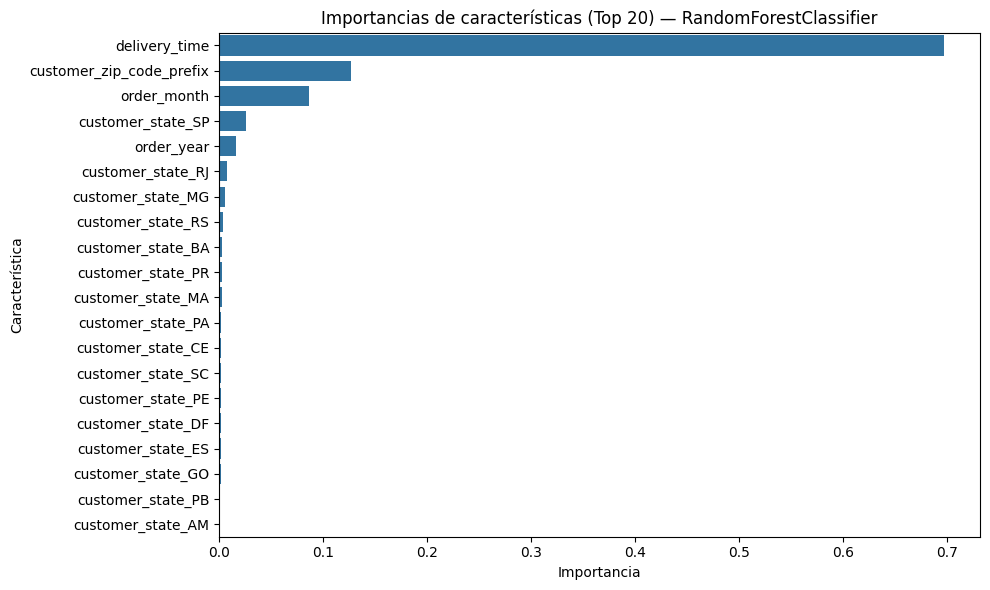

In [10]:
# Importancias de características — Clasificación (RandomForestClassifier)
# Toma el mejor clasificador y, si es un RandomForest, exporta y grafica importancias
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

out_dir = Path('..') / 'data' / '07_model_output'
out_dir.mkdir(parents=True, exist_ok=True)

# Recuperar el mejor clasificador entrenado por nombre y el modelo correspondiente
if 'best_classifier_name' in globals() and 'trained_classification_models' in globals():
    clf_name = best_classifier_name
    best_pipeline = trained_classification_models.get(clf_name)
else:
    clf_name = None
    best_pipeline = None

if best_pipeline is None:
    print('No se encontró el mejor clasificador entrenado. Omite importancias.')
else:
    # En nuestro pipeline el estimador está en el paso 'classifier'
    estimator = getattr(best_pipeline, 'named_steps', {}).get('classifier', None)
    if isinstance(estimator, RandomForestClassifier):
        # Construir nombres de características desde el preprocesador (num + onehot cat)
        try:
            preproc = best_pipeline.named_steps['preprocessor']
            # num features (tal como se definieron en el notebook)
            feat_names = []
            if 'numeric_features' in globals():
                feat_names.extend(list(numeric_features))
            # cat features (obtener nombres expandidos del OHE)
            ohe = preproc.named_transformers_['cat'].named_steps['onehot']
            cat_names = list(ohe.get_feature_names_out(categorical_features))
            feat_names.extend(cat_names)
        except Exception as e:
            # Fallback: intentar con ColumnTransformer
            try:
                feat_names = list(preproc.get_feature_names_out())
            except Exception:
                feat_names = [f'feat_{i}' for i in range(estimator.n_features_in_)]
        importances = estimator.feature_importances_
        # Alinear longitudes por seguridad
        n = min(len(importances), len(feat_names))
        rf_imp_df = (
            pd.DataFrame({'feature': feat_names[:n], 'importance': importances[:n]})
            .sort_values('importance', ascending=False)
        )

        # Guardar CSV
        rf_imp_path = out_dir / 'classification_feature_importances.csv'
        rf_imp_df.to_csv(rf_imp_path, index=False)
        print(f"Importancias (RF) guardadas en: {rf_imp_path}")

        # Cerrar figuras previas para liberar memoria
        plt.close('all')
        
        # Plot top 20
        top_n = rf_imp_df.head(20)
        plt.figure(figsize=(10, 6))
        sns.barplot(data=top_n, x='importance', y='feature', orient='h')
        plt.title(f'Importancias de características (Top 20) — {clf_name}')
        plt.xlabel('Importancia')
        plt.ylabel('Característica')
        plt.tight_layout()
        plt.show()
        plt.close()
    else:
        print(
            f"El mejor clasificador no es RandomForestClassifier (es {type(estimator).__name__}).\n"
            f"Si quieres importancias para este modelo, usa permutation_importance sobre el Pipeline completo."
        )

## Métricas utilizadas y fórmulas

A continuación se listan las fórmulas de las métricas empleadas para evaluar los modelos:

- RMSE (Root Mean Squared Error):  $\mathrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 }$
- MAE (Mean Absolute Error):  $\mathrm{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$
- Coeficiente de determinación:  $R^2 = 1 - \frac{\sum_i (y_i - \hat{y}_i)^2}{\sum_i (y_i - \bar{y})^2}$
- Exactitud (Accuracy):  $\mathrm{Acc} = \frac{TP + TN}{TP + TN + FP + FN}$
- Precisión (Precision):  $\mathrm{Prec} = \frac{TP}{TP + FP}$
- Exhaustividad (Recall):  $\mathrm{Rec} = \frac{TP}{TP + FN}$
- F1-Score:  $\mathrm{F1} = 2 \cdot \frac{\mathrm{Prec} \cdot \mathrm{Rec}}{\mathrm{Prec} + \mathrm{Rec}}$

Donde $TP$ = verdaderos positivos, $TN$ = verdaderos negativos, $FP$ = falsos positivos y $FN$ = falsos negativos. Para regresión, $y_i$ es el valor real, $\hat{y}_i$ la predicción y $\bar{y}$ es la media de $y$. 


## Selección de características

- Señales: delivery_time, ZIP, año, mes, estado.
- Justificación: estacionalidad/geografía influyen; delivery_time correlaciona con retraso.
- Transformaciones: imputación, escalado (num) y OneHot (cat).

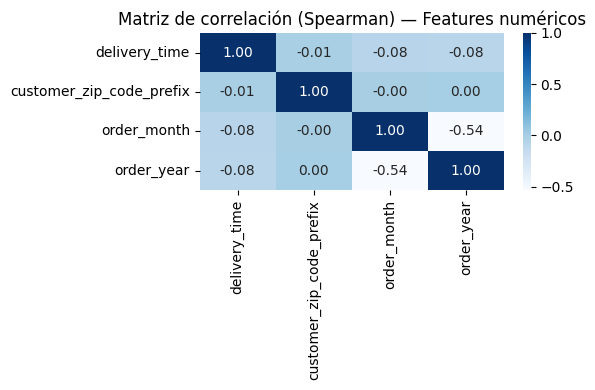

Correlación (Spearman) guardada en: ..\data\08_reports\correlation_spearman.csv


In [11]:
# Análisis de correlación (Spearman) para features numéricos
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path

if 'df' in globals() and 'numeric_features' in globals():
    corr = df[numeric_features].corr(method='spearman')
    
    # Cerrar figuras previas para liberar memoria
    plt.close('all')
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=True)
    plt.title('Matriz de correlación (Spearman) — Features numéricos')
    plt.tight_layout()
    plt.show()
    plt.close()

    # Guardar a reports
    out_dir = Path('..') / 'data' / '08_reports'
    out_dir.mkdir(parents=True, exist_ok=True)
    corr.to_csv(out_dir / 'correlation_spearman.csv')
    print(f"Correlación (Spearman) guardada en: {out_dir / 'correlation_spearman.csv'}")
else:
    print('Variables df/numeric_features no disponibles. Ejecuta celdas de preparación primero.')

## Métricas de clasificación (cuándo usar)

- Accuracy: solo con clases balanceadas.
- Precision: evita falsas alarmas.
- Recall: no dejar pasar retrasos.
- F1: equilibrio con desbalance.
- Umbral: ajustar según costos de negocio.

## Conclusión general

- Los modelos muestran **generalización estable** entre validación y test.
- **Regresión (GradientBoosting):** estima la magnitud del retraso (≈6 días de error).
- **Clasificación (RandomForest):** predice retrasos con F1 ≈ 0.74.
- **Uso propuesto:**
  - Clasificador → alertas tempranas.
  - Regresor → cuantificar el retraso estimado.
- **Siguientes pasos:**
  - Validación temporal (por fechas reales).
  - Ajuste de umbral según costos FP/FN.
  - Incorporar nuevas features (distancia real, categoría, volumen).


En resumen, los modelos generalizan bien y no muestran sobreajuste.
El modelo de clasificación puede anticipar con buena precisión si un pedido se retrasará,
mientras que el de regresión estima cuántos días tardará.
Ambos pueden combinarse: uno para emitir alertas y otro para cuantificar la magnitud del retraso.
A futuro se podría incorporar validación temporal y nuevas variables logísticas para mejorar la precisión.

## Conclusión desde la Perspectiva de Negocio

- Objetivos alcanzados basados en resultados del notebook:
  - Clasificación (RandomForest): Accuracy 96.6%, F1 0.738. Desbalance: 6.5% retrasos; oversampling aplicado en entrenamiento.
  - Regresión (GradientBoosting): RMSE 6.19 días, R² 0.647.

- Hallazgos clave: variables más influyentes — delivery_time, customer_state, order_month.

- Generalización: métricas consistentes entre validación y test; CV de 5 folds estable.

- Uso recomendado:
  - Clasificador → alerta de retraso (sí/no).
  - Regresor → días estimados de retraso.

- Artefactos listos para implementación: modelos, métricas e importancias.

En términos de negocio, estos hallazgos permiten operar de forma más proactiva: el clasificador (RandomForest, F1 ≈ 0.74 y accuracy 96.6% pese al 6.5% de retrasos) habilita alertas tempranas sobre pedidos con alto riesgo de incumplimiento, y el regresor (GradientBoosting, RMSE ≈ 6.2 días, R² ≈ 0.65) cuantifica el retraso esperado para priorizar recursos, ajustar promesas de entrega y anticipar comunicaciones con clientes. Las variables más influyentes —delivery_time, estado del cliente y mes— confirman que carga operativa, geografía y estacionalidad son palancas clave; esto sugiere dimensionar capacidad por región/temporada, revisar SLAs en picos y focalizar iniciativas en segmentos de mayor riesgo. Con un ajuste de umbral según costo FP/FN y validación temporal antes de despliegue, el sistema puede reducir penalizaciones, mejorar NPS y optimizar costos de última milla.